In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [47]:
df = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

In [49]:
df['trip_type'].value_counts(ascending=False)

trip_type
RoundTrip     49497
OneWay          387
CircleTrip      116
Name: count, dtype: int64

In [50]:
df['booking_complete'].value_counts(normalize=True)


booking_complete
0    0.85044
1    0.14956
Name: proportion, dtype: float64

<Axes: xlabel='purchase_lead', ylabel='Count'>

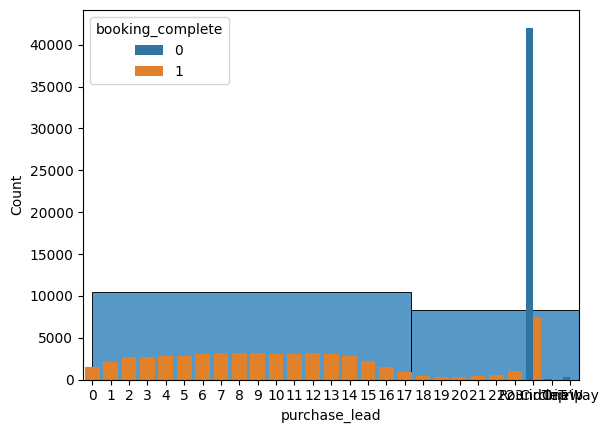

In [51]:
sns.histplot(df['purchase_lead'], bins=50)
sns.countplot(x='flight_hour', data=df)
sns.countplot(x='trip_type', hue='booking_complete', data=df)


In [52]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [53]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [54]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5])

In [55]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


In [56]:
# One-hot encoding for categorical variables
categorical_cols = ['sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [57]:
# Scaling numerical features
numerical_cols = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration']
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [58]:
# Train-test split
X = df.drop('booking_complete', axis=1)
y = df['booking_complete']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [59]:
# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_res).value_counts())


Class distribution after SMOTE:
booking_complete
0    34018
1    34018
Name: count, dtype: int64


In [62]:
# Model Pipeline with GridSearchCV
pipeline = Pipeline([
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

param_grid = {
    'classifier__n_estimators': [100, 120],
    'classifier__max_depth': [None, 5, 10]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=2, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train_res, y_train_res)

print("\nBest Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_


Fitting 2 folds for each of 6 candidates, totalling 12 fits

Best Parameters: {'classifier__max_depth': None, 'classifier__n_estimators': 120}


In [63]:
# Model Evaluation
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nROC AUC Score:", roc_auc_score(y_test, y_proba))


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      8504
           1       0.40      0.27      0.33      1496

    accuracy                           0.83     10000
   macro avg       0.64      0.60      0.61     10000
weighted avg       0.81      0.83      0.82     10000


Confusion Matrix:
[[7904  600]
 [1089  407]]

ROC AUC Score: 0.7806987888052681


In [64]:
# Precision-Recall Curve (more informative for imbalanced data)
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
print("\nPrecision-Recall AUC:", pr_auc)


Precision-Recall AUC: 0.3638485402244863


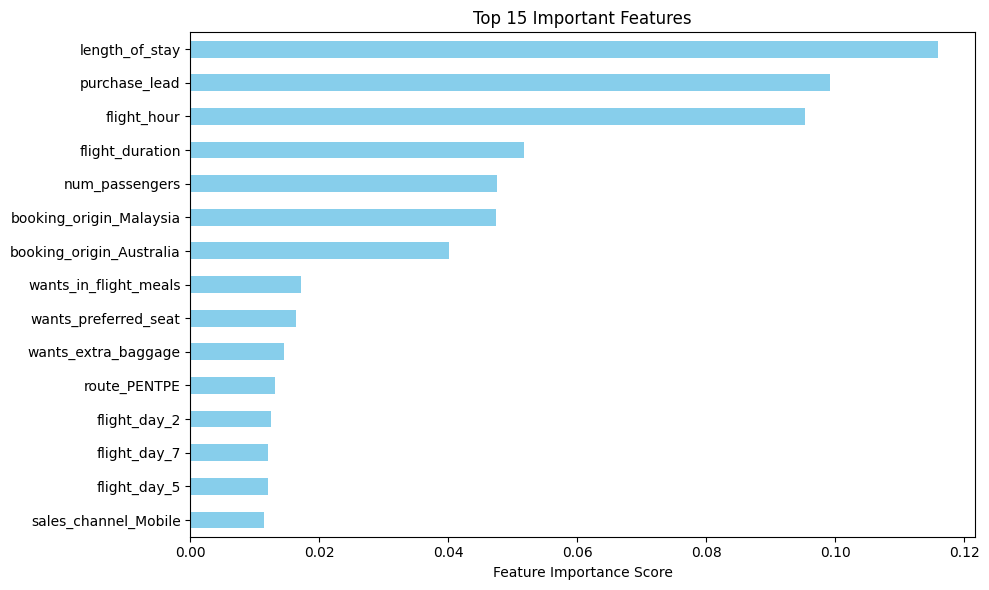

In [65]:
# Feature Importance
importances = pd.Series(best_model.named_steps['classifier'].feature_importances_, index=X.columns)
top_features = importances.nlargest(15).sort_values(ascending=True)

plt.figure(figsize=(10, 6))
top_features.plot(kind='barh', color='skyblue')
plt.title("Top 15 Important Features")
plt.xlabel("Feature Importance Score")
plt.tight_layout()
plt.show()